<a href="https://colab.research.google.com/github/NOKOGIDO/Time-to-Event/blob/main/Modelos/PC_Hazard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PC-Hazard Método**
A continuación se muestra un ejemplo simple del método PC-Hazard estudiado en el [*paper*](https://arxiv.org/abs/1910.06724).

In [ ]:
!git clone https://github.com/havakv/pycox.git

Cloning into 'pycox'...
remote: Enumerating objects: 1752, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1752 (delta 81), reused 115 (delta 67), pack-reused 1603
Receiving objects: 100% (1752/1752), 2.51 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (1138/1138), done.


In [ ]:
! pip install sklearn-pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [ ]:
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2435 sha256=abe7d9be60743c57c796a0fe30b13e7d49ec41d0374e44f540c41d0221119bf4
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5ddef243

Pycox está construido sobre PyTorch y torchtuples, esto nos ayuda a entrenar redes neuronales con menos código repetitivo.

In [ ]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

Importamos el dataset, el modelo LogisticHazard también conocido como Nnet-Survival y EvalSurv que simplifica el procedimiento de evaluación.

In [ ]:
from pycox.datasets import metabric
#from pycox.datasets import support
#from pycox.datasets import gbsg
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(2587)
_ = torch.manual_seed(258)

# **Dataset**
Cargamos el dataset METABRIC (en este apartado podemos cambiar para seleccionar el dataset Rot. & GBSG o el dataset SUPPORT) y hacemos las particiones de entrenamiento, test y validación.
La columna **duration** proporciona los tiempos observados y la columna **event** contiene indicadores de si la observación es un **evento** (1) o una **observación censurada** (0).

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1
8,5.865741,6.738176,10.850687,5.596416,0.0,0.0,0.0,1.0,68.209999,150.600006,1
11,6.333529,5.170259,8.742507,6.500216,0.0,1.0,1.0,0.0,55.020000,141.166672,0


# **Transformación de Características**
Tenemos una serie de variables, además de las duraciones e indicadores de eventos.

Estandarizamos las variables numéricas y mantenemos las variables binarias. Las variables deben ser de tipo 'float32', ya que es necesario para el correcto funcionamiento de pytorch. Dependiendo del dataset seleccionado, debemos ajustar el número y tipo de variables, para su estandarización.

Utilizamos **sklearn_pandas.DataFrameMapper** para hacer un mapeo de características.

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# **Transformación de etiquetas**
Los métodos de supervivencia requieren transformaciones de etiquetas individuales, por lo que hemos incluido una **label_transform**, esta es solo una abreviatura de la clase **pycox.preprocessing.label_transforms.LabTransDiscreteTime.**

PC-Hazard es un método de tiempo continuo, pero requiere definir intervalos en los que el riesgo es constante. Por tanto, necesitamos realizar una operación similar a una discretización de la escala de tiempo. Dejamos que **num_durations** defina el tamaño de esta cuadrícula de discretización (equidistante), lo que significa que nuestra red tendrá **num_durations** nodos de salida.

In [ ]:
num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

/usr/local/lib/python3.10/dist-packages/pycox/preprocessing/label_transforms.py:219: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [ ]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

Tenga en cuenta que **y_train** ahora consta de tres etiquetas: **el índice de intervalo**, **el indicador de evento** y la **proporción del intervalo antes de que ocurra el evento/censura** (i.e, * en el [*paper*](https://arxiv.org/abs/1910.06724)).

In [ ]:
y_train

(array([2, 1, 4, ..., 4, 1, 5]),
 array([0., 1., 1., ..., 0., 1., 0.], dtype=float32),
 array([0.95869744, 0.6957903 , 0.25933278, ..., 0.69221616, 0.1278792 ,
        0.91044474], dtype=float32))

# **Neural net**
Creamos una MLP simple (Perceptrón Multicapa) con dos capas ocultas, activación ReLU, y **num_nodes** nodos de salida. También utilizamos **normalización batch** y **dropout** entre capas.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

# **Entrenamiento del modelo**
Para entrenar el modelo, es necesario definir un optimizador. En este caso se emplea tt.optim para la selección, ya que tiene alguna funcionalidad adicional. Se utiliza el optimizador Adam, pero en lugar de elegir una tasa de aprendizaje, usaremos el esquema propuesto por [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) para encontrar una tasa de aprendizaje adecuada **con model.lr_finder.** Puede consultar [esta publicación](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) para obtener una explicación más detallada.

También configuramos el índice de duración que conecta los nodos de salida de la red con los tiempos de discretización. Esto sólo es útil para la predicción y no afecta el procedimiento de entrenamiento.

In [ ]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

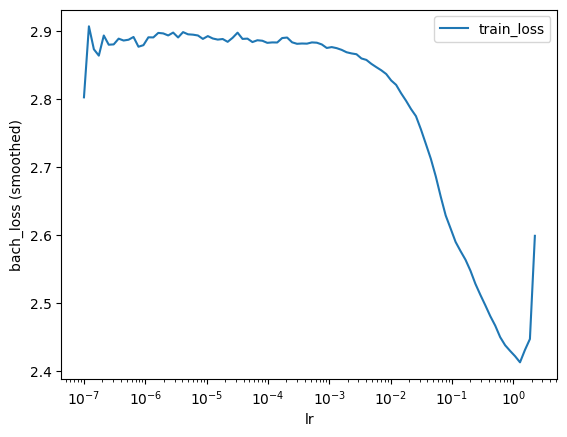

In [ ]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [ ]:
lr_finder.get_best_lr()

0.12915496650148922

A menudo, esta tasa de aprendizaje es algo elevada, por lo que la configuramos manualmente en 0,01.

In [ ]:
model.optimizer.set_lr(0.01)

También se incluye **EarlyStoping** para detener el entrenamiento cuando la función de pérdida de validación deje de mejorar. Después del entrenamiento, se cargará el modelo con mejor rendimiento en términos de función de pérdida de la validación.


In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.7493,	val_loss: 2.9532
1:	[0s / 0s],		train_loss: 2.4679,	val_loss: 2.6342
2:	[0s / 0s],		train_loss: 2.2650,	val_loss: 2.2454
3:	[0s / 0s],		train_loss: 2.0037,	val_loss: 1.8828
4:	[0s / 0s],		train_loss: 1.7715,	val_loss: 1.6318
5:	[0s / 0s],		train_loss: 1.6216,	val_loss: 1.5091
6:	[0s / 0s],		train_loss: 1.5621,	val_loss: 1.4883
7:	[0s / 0s],		train_loss: 1.5123,	val_loss: 1.4830
8:	[0s / 0s],		train_loss: 1.5055,	val_loss: 1.4807
9:	[0s / 0s],		train_loss: 1.4969,	val_loss: 1.4779
10:	[0s / 0s],		train_loss: 1.4880,	val_loss: 1.4805
11:	[0s / 0s],		train_loss: 1.4759,	val_loss: 1.4725
12:	[0s / 0s],		train_loss: 1.4781,	val_loss: 1.4868
13:	[0s / 0s],		train_loss: 1.4646,	val_loss: 1.4986
14:	[0s / 0s],		train_loss: 1.4531,	val_loss: 1.4910
15:	[0s / 0s],		train_loss: 1.4543,	val_loss: 1.4801
16:	[0s / 0s],		train_loss: 1.4377,	val_loss: 1.4777
17:	[0s / 0s],		train_loss: 1.4522,	val_loss: 1.4875
18:	[0s / 1s],		train_loss: 1.4258,	val_loss: 1.4849
19:

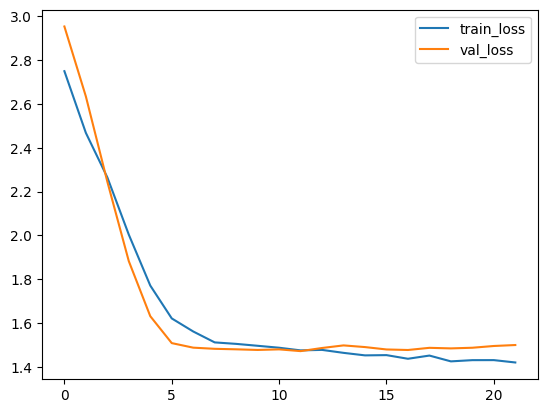

In [ ]:
_ = log.plot()

# **Predicción**
Para la evaluación, primero necesitamos obtener estimaciones de supervivencia para el conjunto de prueba. Esto se puede hacer con **model.predict_surv** que devuelve una serie de estimaciones de supervivencia, o con **model.predict_surv_df** que devuelve las estimaciones de supervivencia como un marco de datos.
Sin embargo, necesitamos definir en cuántos puntos queremos obtener las predicciones. El valor predeterminado (**model.sub = 1**) solo utiliza los nudos de intervalo, pero al aumentar los argumentos de **model.sub**, reemplazamos los nudos con un número equidistante de puntos en cada intervalo. Esto es muy similar a la interpolación de métodos discretos como **LogisticHazard** y **PMF**.

In [ ]:
surv = model.predict_surv_df(x_test)

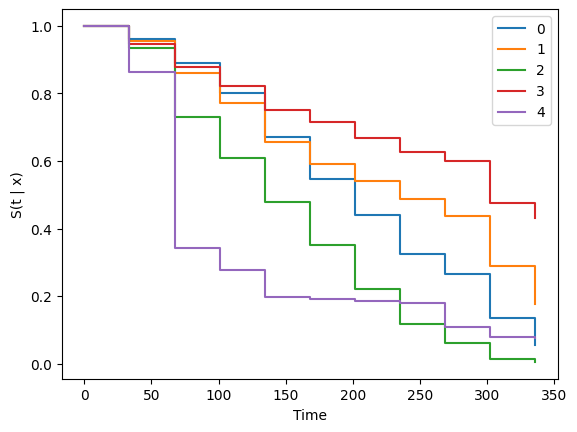

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
model.sub = 10

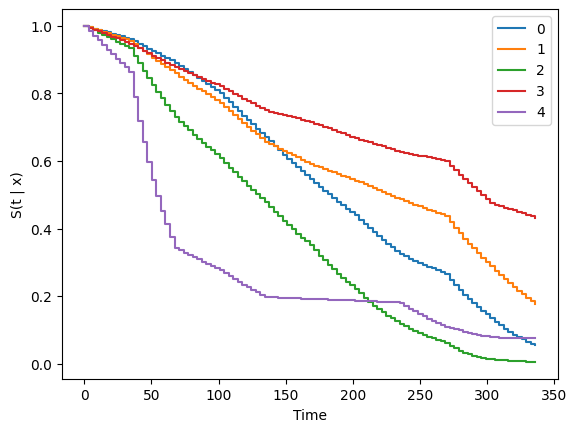

In [ ]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# **Evaluación**
La clase **EvalSurv** contiene algunos criterios de evaluación útiles para la predicción del tiempo hasta el evento. Configuramos **censor_surv = 'km'** para indicar que queremos usar **Kaplan-Meier** para estimar la distribución de censura.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


# **Concordancia**
Comenzamos con la concordancia **event-time** de [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).



In [ ]:
ev.concordance_td('antolini')

0.6351289230640645

# **Brier Score**
Podemos trazar la puntuación de [IPCW Brier](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) para un conjunto de tiempos determinado. Aquí solo usamos 100 puntos de tiempo entre la duración mínima y máxima en el conjunto de prueba. Tenga en cuenta que la puntuación se vuelve inestable para los tiempos más altos. Por lo tanto, es común ignorar la parte más derecha del gráfico.

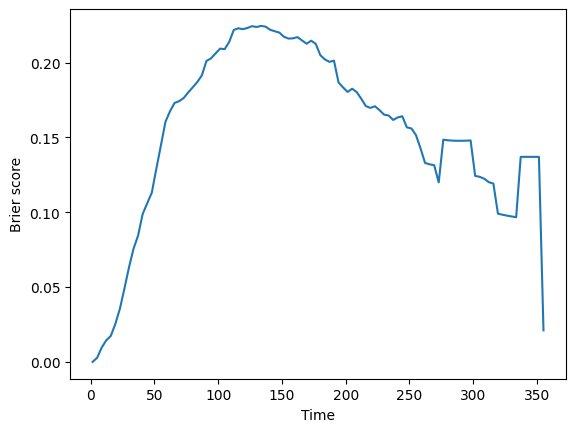

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

# **Negative binomial log-likelihood**
De manera similar, podemos trazar el [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

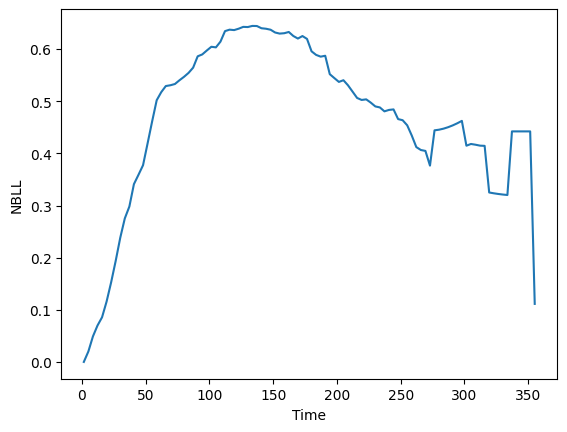

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

# **Integrated scores**
Las dos puntuaciones anteriores dependientes del tiempo se pueden integrar a lo largo del tiempo para producir una puntuación única [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). En la práctica, esto se hace mediante integración numérica sobre una cuadrícula de tiempo definida.

In [ ]:
ev.integrated_brier_score(time_grid)

0.15487625406721547

In [ ]:
ev.integrated_nbll(time_grid)

0.4697100674396022